# Regression on different datasets using the new kernel

In [10]:
import matplotlib.pyplot as plt # 3.6
import numpy as np # 1.22.4
import tensorflow as tf # 2.11.0
import gpflow # 2.7.0
import pandas as pd
import tensorflow_probability as tfp
from tensorflow import keras
import seaborn as sns
import torch
from tensorflow.python.ops.numpy_ops import np_config
from LambdaRBF import LambdaRBF
from utils import plot_matrix, compare_matrix, get_lower_triangular_from_diag, create_dataset, measure_rmse, train_GPR_LRBF_model, train_GPR_RBF_model
np_config.enable_numpy_behavior()
plt.rcParams["figure.figsize"] = (12, 6)
plt.style.use("ggplot")
print('tensorflow ', tf.__version__) 
print('pytorch ', torch.__version__) 
print('numpy ', np.__version__) 
print('gpflow ', gpflow.__version__) 
print('pandas ', pd.__version__) 

tensorflow  2.11.0
pytorch  1.13.1
numpy  1.22.4
gpflow  2.7.0
pandas  1.5.3


Load Boston dataset

In [29]:
X_train, Y_train,  X_test, Y_test, Y_train_mean, Y_train_std = create_dataset('boston', 0)
D = X_train.shape[1]

Show that the Lambda RBF kernel is equivalent in the computation of the kernel matrix

In [12]:
# Define the lengthscales according to the standard RBF kernel
lengthscales = tf.constant([D**0.5]*D, dtype=tf.float64)
# Obtain the matrix L such that LLᵀ=Λ and Λ=inv(diag(lengthscales))
Lambda_L = get_lower_triangular_from_diag(lengthscales)
# Convert it into the triangular (array) representation
Lambda_L_array = tfp.math.fill_triangular_inverse(Lambda_L)

LRBF = LambdaRBF(Lambda_L_array, 1.0)
lrbf = LRBF.K(X_train)[5,3]

# Standard RBF kernel
RBF = gpflow.kernels.SquaredExponential(variance=1, lengthscales=(D**0.5)*np.ones(D))
rbf = RBF.K(X_train)[5,3]
print('LambdaRBF val: ', lrbf)
print('RBF val: \t',rbf)

LambdaRBF val:  tf.Tensor(0.3518335889365919, shape=(), dtype=float64)
RBF val: 	 tf.Tensor(0.3518335889365918, shape=(), dtype=float64)


Obtain the LRBF for a generic matrix (not diagonal)

In [13]:
ts = gpflow.utilities.bijectors.triangular_size(D)
# Define an array that represents the entire L matrix
Lambda_L_array_full = tf.constant([D**0.5]*ts, dtype=tf.float64)

LRBF = LambdaRBF(Lambda_L_array_full, 1.0)
LRBF.K(X_train)[5,3]

<tf.Tensor: shape=(), dtype=float64, numpy=0.0>

## Compare the RBF kernel with LambdaRBF with equivalent starting lengthscales

### The Covariance matrix

We are going to extend the Automatic Relevance Determination techique tipically used togheter with stationary kernels like Squared Exponential (RBF).

We are working on the prior probabability $p(\textbf{f}|\Theta)$. The prior knowledge is expressed by the precomputed Kernel matrix $K_{xx|\Theta}$ where $K_{xx|\Theta}[i,j] = k(x_i,x_j|\Theta)$. \\
The RBF kernel function $k$ is defined as:
$$k(x_i,x_j|\sigma_f^2,\Lambda) = \sigma_f^2e^{-\frac{1}{2}(x_i-x_j)^T\Lambda(x_i-x_j)}$$
where $\Lambda$ is the precision matrix of the kernel.

In ARD the precision matrix of the kernel is of the form:
$$diag([\alpha_0,\alpha_1,...,\alpha_{D-1}])$$ 
where $D$ is the number of features. The values on the diagonal are called lengthscales because they represent a form of scaling of the squared norm that is computed among couples of feature vectors. 

What we are willing to do is extending the ARD mechanism to a more general one where we can optimize for the entire precision matrix $\Lambda$ instead of only the diagonal (explain here the link between a zero in the precision matrix and conditional independence). For this purpose we are going to design a modified version of the RBF kernel in which the trainable hyperparameters are $\sigma_f^2$ and the full matrix $\Lambda$

In [14]:
l_i = D**0.5
lengthscales_array = l_i*np.ones(D)
print('Lengthscales: ', lengthscales_array)

Lengthscales:  [3.60555128 3.60555128 3.60555128 3.60555128 3.60555128 3.60555128
 3.60555128 3.60555128 3.60555128 3.60555128 3.60555128 3.60555128
 3.60555128]


$$k(x_i,x_j|\sigma_f^2,\Lambda) = \sigma_f^2e^{||\frac{x_i-x_j}{\textbf{l}}||^2}$$
where $\textbf{l}$ is a $D$-dimensional array containing the lengthscales of each dimension $[l_0,l_1,...,l_{D-1}]$. If we suppose $D=2$ we can express the scaled norm between two samples as:
$$||\frac{x_i-x_j}{\textbf{l}}||^2 = (x_i-x_j)^T\begin{bmatrix} \lambda_0 & 0 \\ 0 & \lambda_1 \end{bmatrix}(x_i-x_j) = \lambda_0(x_{i,0}-x_{j,0})^2 + \lambda_1(x_{i,1}-x_{j,1})^2$$

$$||\frac{x_i-x_j}{\textbf{l}}||^2 = (\frac{x_i-x_j}{l_0})^T(\frac{x_i-x_j}{l_1}) = \begin{bmatrix}\frac{x_{i,0}-x_{j,0}}{l_0} & \frac{x_{i,1}-x_{j,1}}{l_1}\end{bmatrix}\begin{bmatrix}\frac{x_{i,0}-x_{j,0}}{l_0} \\ \frac{x_{i,1}-x_{j,1}}{l_1}\end{bmatrix} = \frac{1}{l_0^2}(x_{i,0}-x_{j,0})^2 + \frac{1}{l_1^2}(x_{i,1}-x_{j,1})^2$$

$$\lambda_i = \frac{1}{l_i^2}$$
$$l_i = \sqrt{\frac{1}{\lambda_i}}$$

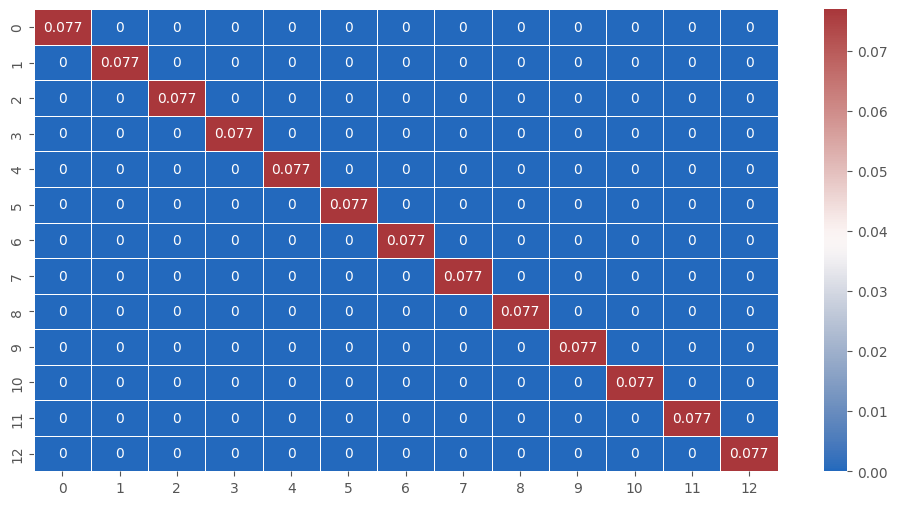

In [15]:
lengthscales = tf.constant([l_i]*D, dtype=tf.float64)
Lambda_L = get_lower_triangular_from_diag(lengthscales)
Lambda = tf.matmul(Lambda_L, tf.transpose(Lambda_L))
plot_matrix(Lambda)

In [16]:
print('lambda_i = %.3f'%(1/l_i**2))

lambda_i = 0.077


### LambdaRBF kernel - no priors

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.Lambda_L,Parameter,Identity,,True,"(91,)",float64,"[0.27735, 0., 0...."
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


--- Initial values ---
Variance: 1.000
Lambda diagonal:  [0.07692308 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308
 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308
 0.07692308]
--- Final values ---
Variance: 1.685


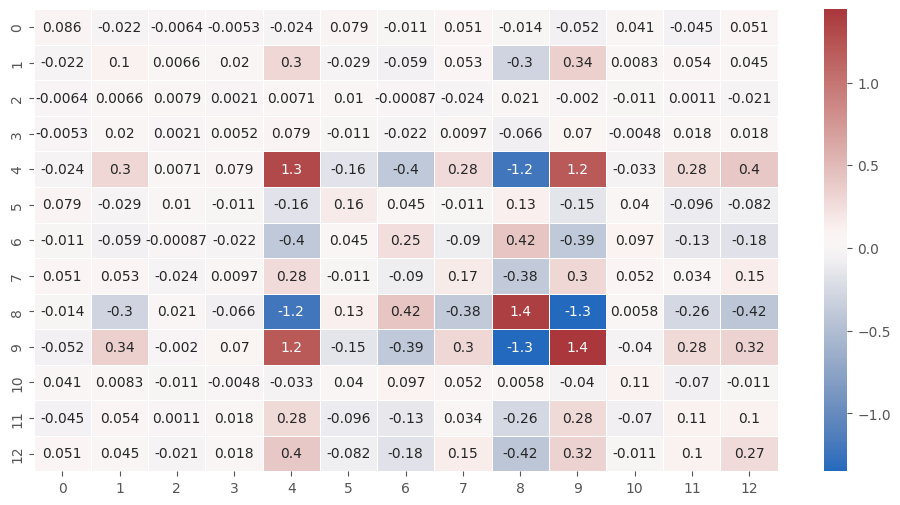

In [30]:
model_LRBF = train_GPR_LRBF_model(X_train, Y_train)

In [18]:
train_rmse_stan, test_rmse_stan = measure_rmse(model_LRBF, X_train, Y_train, X_test, Y_test)
print('Train RMSE (Standardised): %.3f'%(train_rmse_stan))
print('Test RMSE (Standardised): %.3f'%(test_rmse_stan))

Train RMSE (Standardised): 0.125
Test RMSE (Standardised): 0.483


### RBF kernel (standard) - no priors

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(13,)",float64,"[3.60555, 3.60555, 3.60555..."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


--- Initial values ---
Variance: 1.000
Lengthscales:  [3.60555128 3.60555128 3.60555128 3.60555128 3.60555128 3.60555128
 3.60555128 3.60555128 3.60555128 3.60555128 3.60555128 3.60555128
 3.60555128]
--- Final values ---
Variance: 1.449
Lengthscales:  [6.56772382e+00 1.02828585e+01 1.85135772e+03 3.83219134e+03
 6.75633633e-01 3.14068147e+00 3.94581257e+00 5.02214116e+00
 4.56209545e+00 1.22476976e+00 4.83424957e+00 9.68222842e+00
 1.84917395e+00]


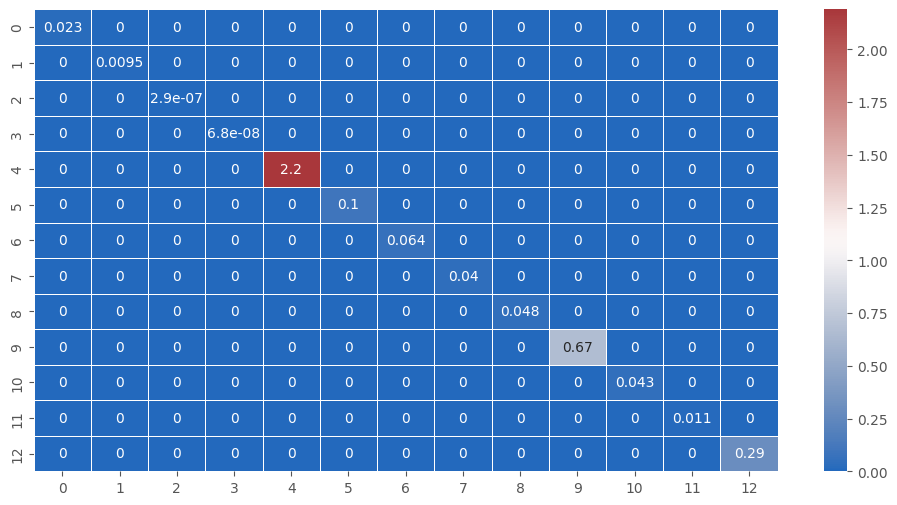

In [19]:
model_RBF = train_GPR_RBF_model(X_train, Y_train)

In [20]:
train_rmse_stan, test_rmse_stan = measure_rmse(model_RBF, X_train, Y_train, X_test, Y_test)
print('Train RMSE (Standardised): %.3f'%(train_rmse_stan))
print('Test RMSE (Standardised): %.3f'%(test_rmse_stan))

Train RMSE (Standardised): 0.142
Test RMSE (Standardised): 0.436


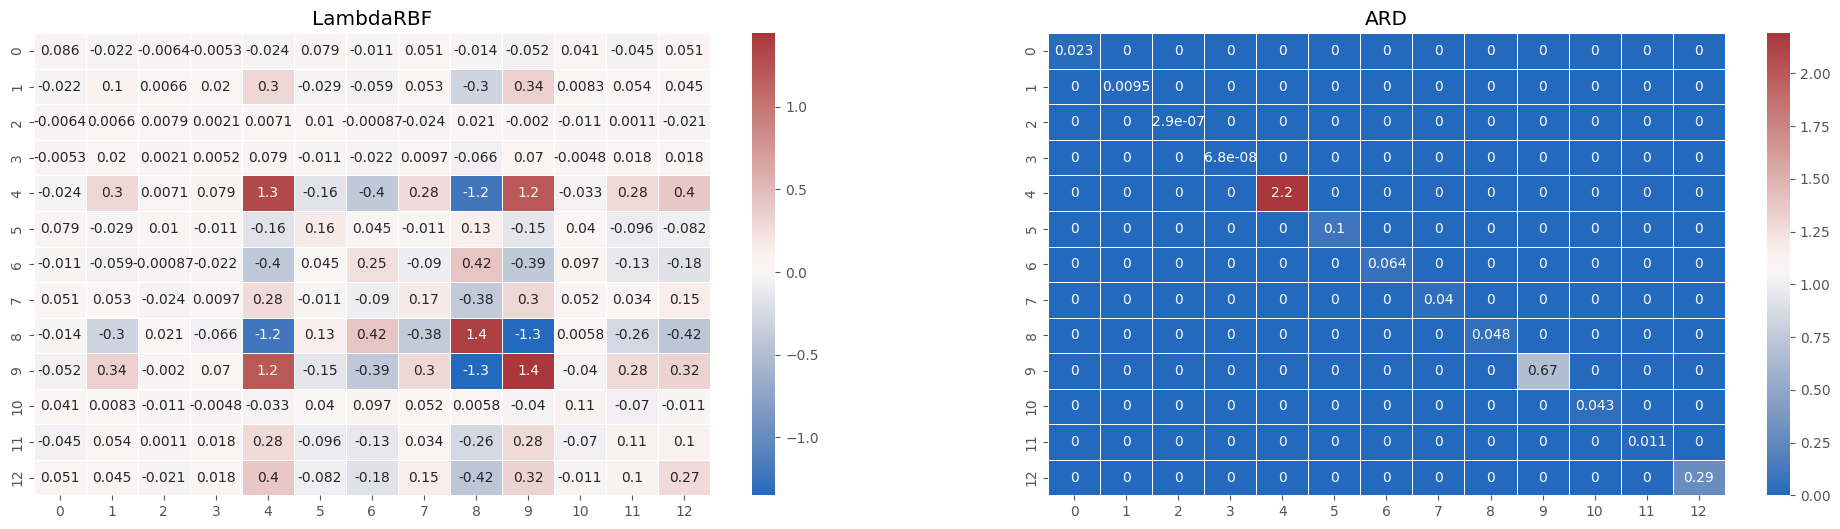

In [21]:
Lambda_LRBF = model_LRBF.kernel.get_Lambda()
Lambda_L_RBF = get_lower_triangular_from_diag(model_RBF.kernel.lengthscales.numpy())
Lambda_RBF = tf.matmul(Lambda_L_RBF, tf.transpose(Lambda_L_RBF))
compare_matrix(Lambda_LRBF, Lambda_RBF)

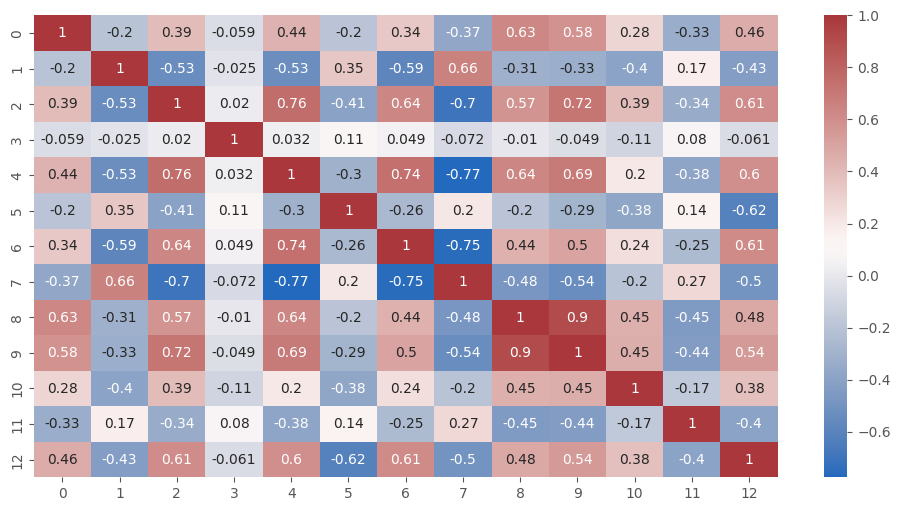

In [22]:
plot_matrix(X_train, correlation=True)

## Introducing a prior on hyperparameters

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.Lambda_L,Parameter,Identity,Normal,True,"(91,)",float64,"[0.27735, 0., 0...."
GPR.kernel.variance,Parameter,Softplus,Normal,True,(),float64,1.0
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


--- Initial values ---
Variance: 1.000
Lambda diagonal:  [0.07692308 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308
 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308
 0.07692308]
--- Final values ---
Variance: 1.452


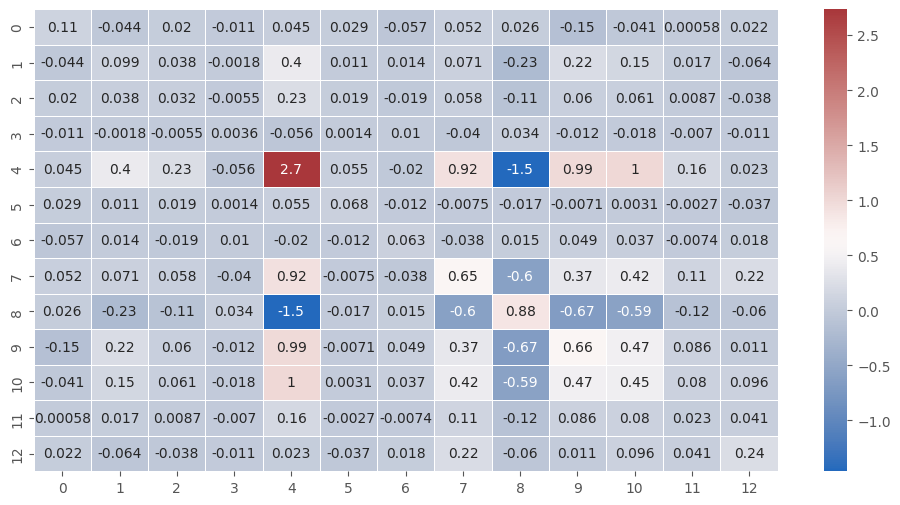

In [15]:
Lambda_L_prior = tfp.distributions.Normal(loc=gpflow.utilities.to_default_float(1.), scale=gpflow.utilities.to_default_float(1.))
variance_prior = tfp.distributions.Normal(loc=gpflow.utilities.to_default_float(0.05), scale=gpflow.utilities.to_default_float(1.))
prior = {'Lambda_L_prior':Lambda_L_prior, 'variance_prior':variance_prior}
model_LRBF = train_GPR_LRBF_model(X_train, Y_train, prior=prior)


In [16]:
train_rmse_stan, test_rmse_stan = measure_rmse(model_LRBF, X_train, Y_train, X_test, Y_test)
print('Train RMSE (Standardised): %.3f'%(train_rmse_stan))
print('Test RMSE (Standardised): %.3f'%(test_rmse_stan))

Train RMSE (Standardised): 0.123
Test RMSE (Standardised): 0.439


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,Normal,True,(),float64,1.0
GPR.kernel.lengthscales,Parameter,Softplus,Normal,True,"(13,)",float64,"[3.60555, 3.60555, 3.60555..."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


--- Initial values ---
Variance: 1.000
Lengthscales:  [3.60555128 3.60555128 3.60555128 3.60555128 3.60555128 3.60555128
 3.60555128 3.60555128 3.60555128 3.60555128 3.60555128 3.60555128
 3.60555128]
--- Final values ---
Variance: 0.795
Lengthscales:  [2.61240352 3.59217637 2.66340039 4.14535633 0.85577215 2.46983157
 2.74945467 2.70302672 2.01870868 1.03129203 2.73359412 3.25322002
 1.78116227]


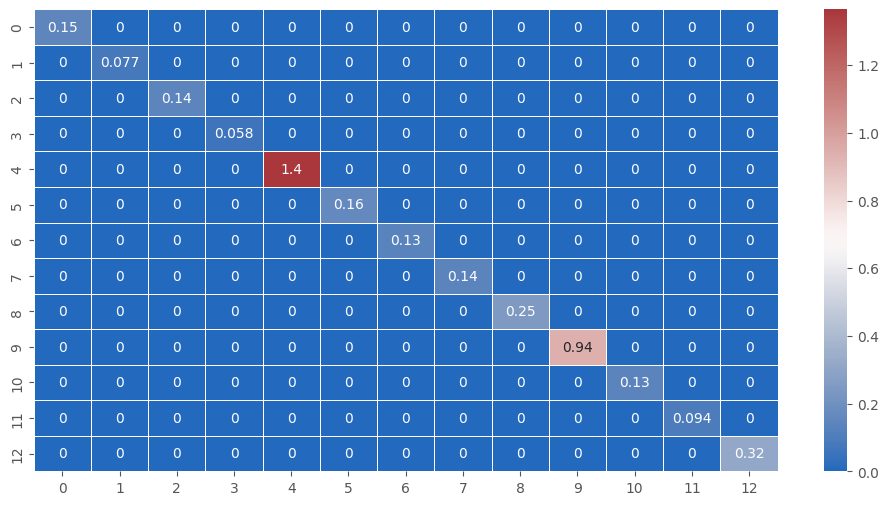

In [17]:
lengthscales_prior = tfp.distributions.Normal(loc=gpflow.utilities.to_default_float(1.), scale=gpflow.utilities.to_default_float(1.))
variance_prior = tfp.distributions.Normal(loc=gpflow.utilities.to_default_float(0.05), scale=gpflow.utilities.to_default_float(1.))
prior = {'lengthscales_prior':lengthscales_prior, 'variance_prior':variance_prior}
model_RBF = train_GPR_RBF_model(X_train, Y_train, prior=prior)


In [18]:
train_rmse_stan, test_rmse_stan = measure_rmse(model_RBF, X_train, Y_train, X_test, Y_test)
print('Train RMSE (Standardised): %.3f'%(train_rmse_stan))
print('Test RMSE (Standardised): %.3f'%(test_rmse_stan))

Train RMSE (Standardised): 0.115
Test RMSE (Standardised): 0.425


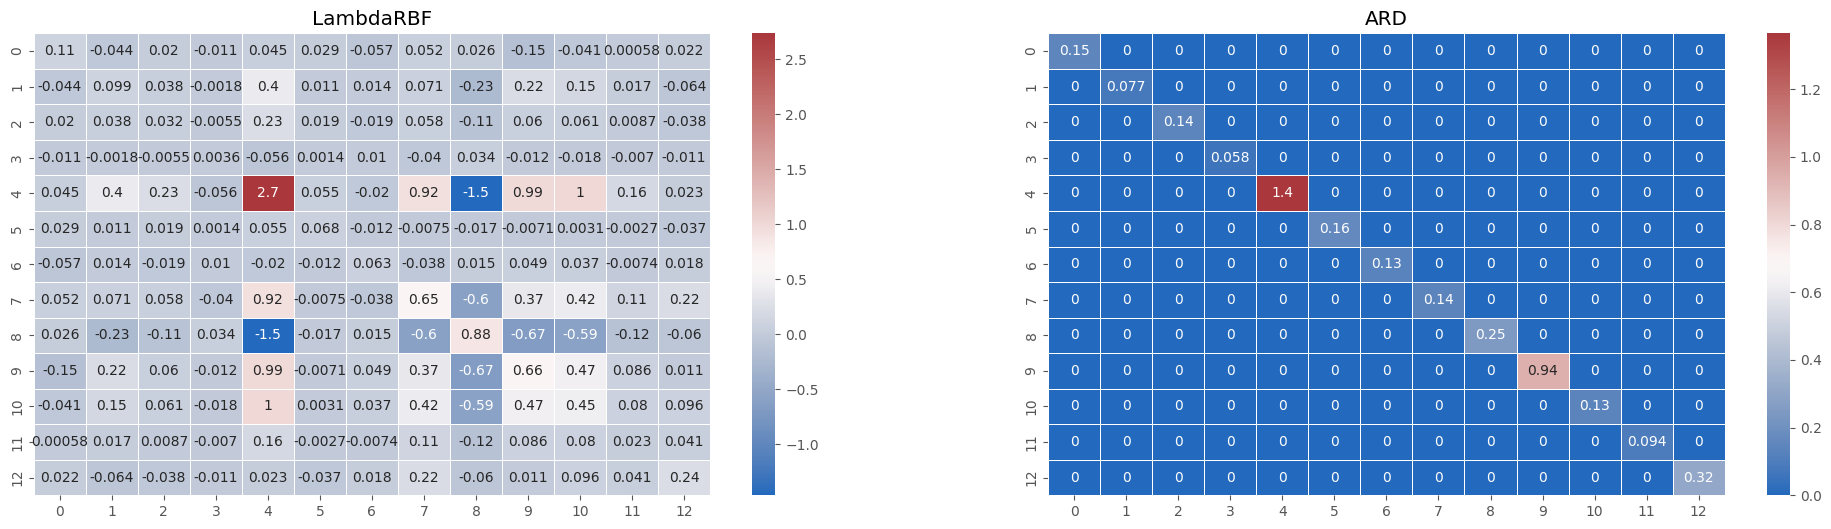

In [19]:
Lambda_LRBF = model_LRBF.kernel.get_Lambda()
Lambda_L_RBF = get_lower_triangular_from_diag(model_RBF.kernel.lengthscales.numpy())
Lambda_RBF = tf.matmul(Lambda_L_RBF, tf.transpose(Lambda_L_RBF))
compare_matrix(Lambda_LRBF, Lambda_RBF)

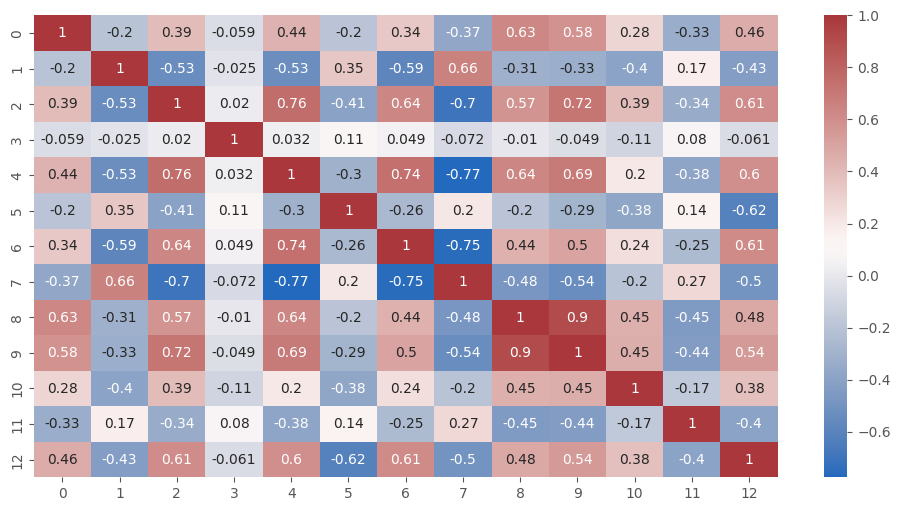

In [20]:
plot_matrix(X_train, correlation=True)

## Yacth dataset

In [23]:
X_train, Y_train,  X_test, Y_test, Y_train_mean, Y_train_std = create_dataset('yacht', 0)
D = X_train.shape[1]

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.Lambda_L,Parameter,Identity,,True,"(21,)",float64,"[0.40825, 0., 0...."
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


--- Initial values ---
Variance: 1.000
Lambda diagonal:  [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
--- Final values ---
Variance: 5.721


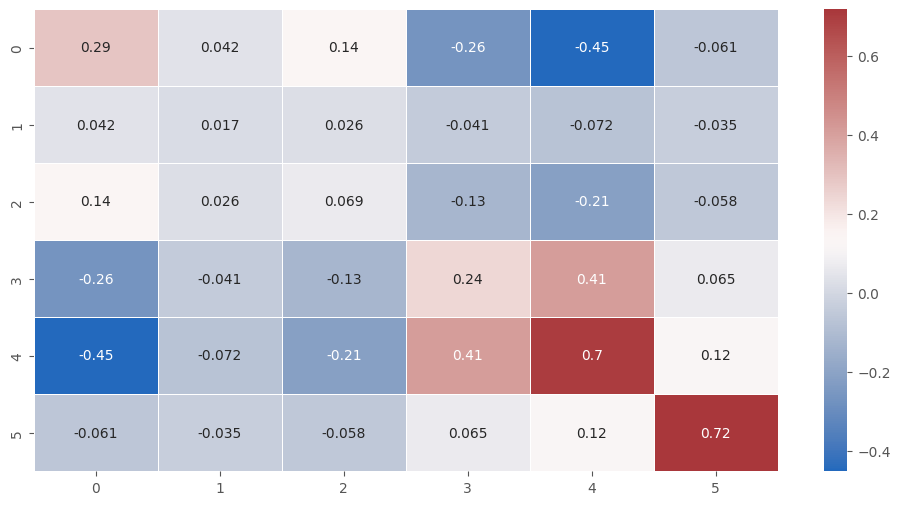

In [24]:
model_LRBF = train_GPR_LRBF_model(X_train, Y_train)

In [25]:
train_rmse_stan, test_rmse_stan = measure_rmse(model_LRBF, X_train, Y_train, X_test, Y_test)
print('Train RMSE (Standardised): %.3f'%(train_rmse_stan))
print('Test RMSE (Standardised): %.3f'%(test_rmse_stan))

Train RMSE (Standardised): 0.010
Test RMSE (Standardised): 0.020


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(6,)",float64,"[2.44949, 2.44949, 2.44949..."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


--- Initial values ---
Variance: 1.000
Lengthscales:  [2.44948974 2.44948974 2.44948974 2.44948974 2.44948974 2.44948974]
--- Final values ---
Variance: 0.742
Lengthscales:  [5.23417794e+00 4.43086052e+00 4.00634789e+03 7.11481299e+00
 1.86828911e+00 4.01687729e-01]


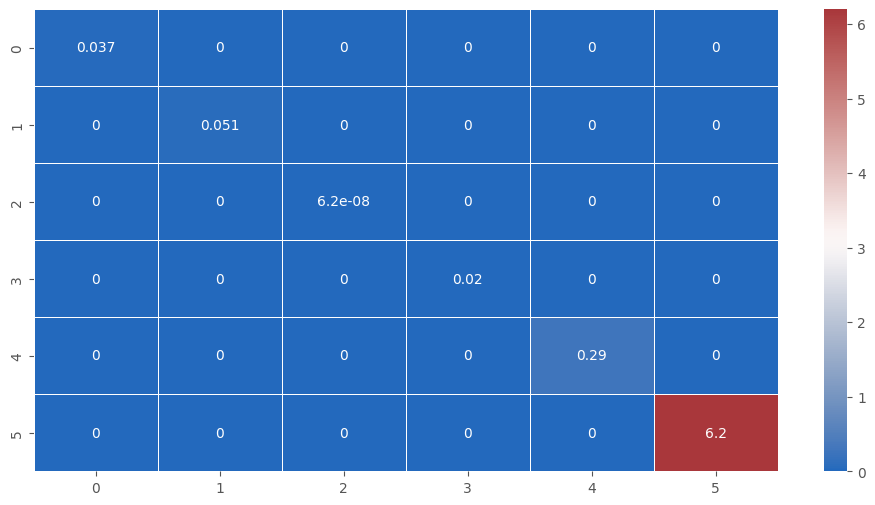

In [26]:
model_RBF = train_GPR_RBF_model(X_train, Y_train)

In [25]:
train_rmse_stan, test_rmse_stan = measure_rmse(model_RBF, X_train, Y_train, X_test, Y_test)
print('Train RMSE (Standardised): %.3f'%(train_rmse_stan))
print('Test RMSE (Standardised): %.3f'%(test_rmse_stan))

Train RMSE (Standardised): 0.000
Test RMSE (Standardised): 0.039


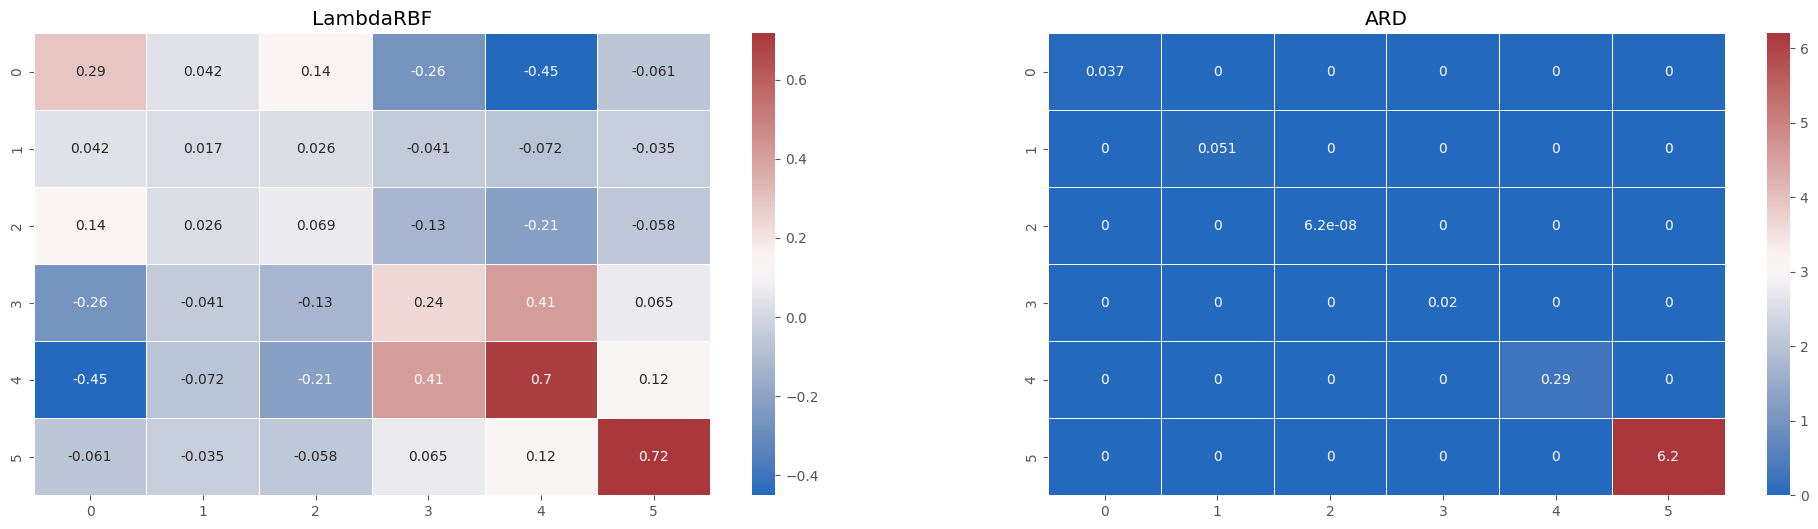

In [26]:
Lambda_LRBF = model_LRBF.kernel.get_Lambda()
Lambda_L_RBF = get_lower_triangular_from_diag(model_RBF.kernel.lengthscales.numpy())
Lambda_RBF = tf.matmul(Lambda_L_RBF, tf.transpose(Lambda_L_RBF))
compare_matrix(Lambda_LRBF, Lambda_RBF)

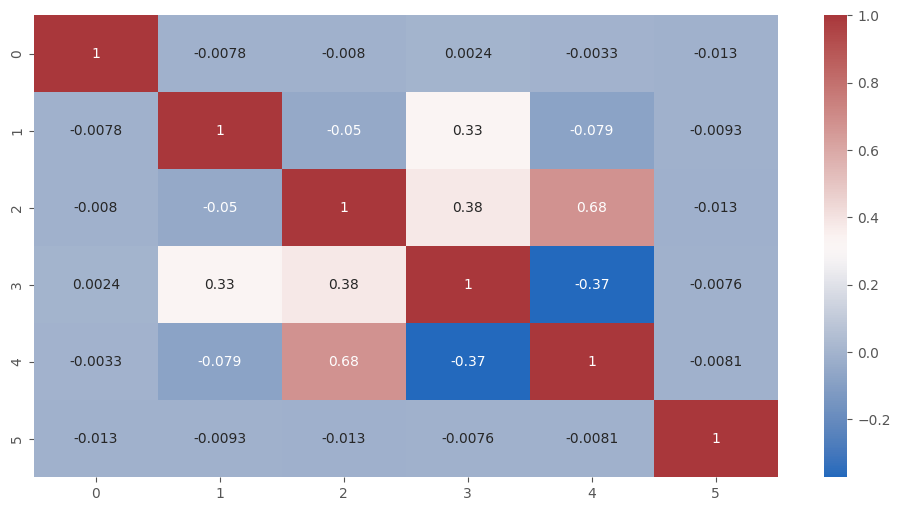

In [27]:
plot_matrix(X_train, correlation=True)

## Concrete dataset

In [27]:
X_train, Y_train,  X_test, Y_test, Y_train_mean, Y_train_std = create_dataset('concrete', 0)
D = X_train.shape[1]

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.Lambda_L,Parameter,Identity,,True,"(36,)",float64,"[0.35355, 0., 0...."
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


--- Initial values ---
Variance: 1.000
Lambda diagonal:  [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
--- Final values ---
Variance: 1.465


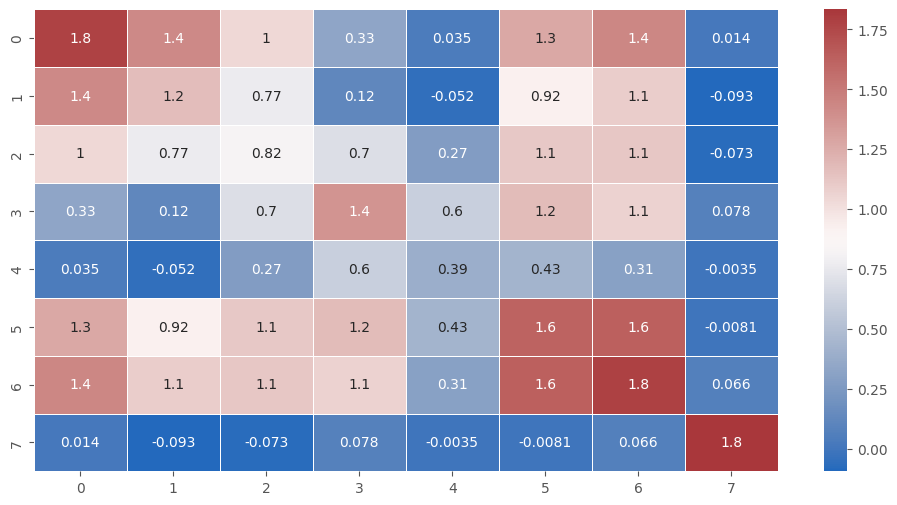

In [28]:
model_LRBF = train_GPR_LRBF_model(X_train, Y_train)

In [30]:
train_rmse_stan, test_rmse_stan = measure_rmse(model_LRBF, X_train, Y_train, X_test, Y_test)
print('Train RMSE (Standardised): %.3f'%(train_rmse_stan))
print('Test RMSE (Standardised): %.3f'%(test_rmse_stan))

Train RMSE (Standardised): 0.193
Test RMSE (Standardised): 0.270


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(8,)",float64,"[2.82843, 2.82843, 2.82843..."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


--- Initial values ---
Variance: 1.000
Lengthscales:  [2.82842712 2.82842712 2.82842712 2.82842712 2.82842712 2.82842712
 2.82842712 2.82842712]
--- Final values ---
Variance: 2.293
Lengthscales:  [3.01282719 3.8466048  2.27175015 1.07209503 2.99757784 4.46009074
 3.62311958 0.83515552]


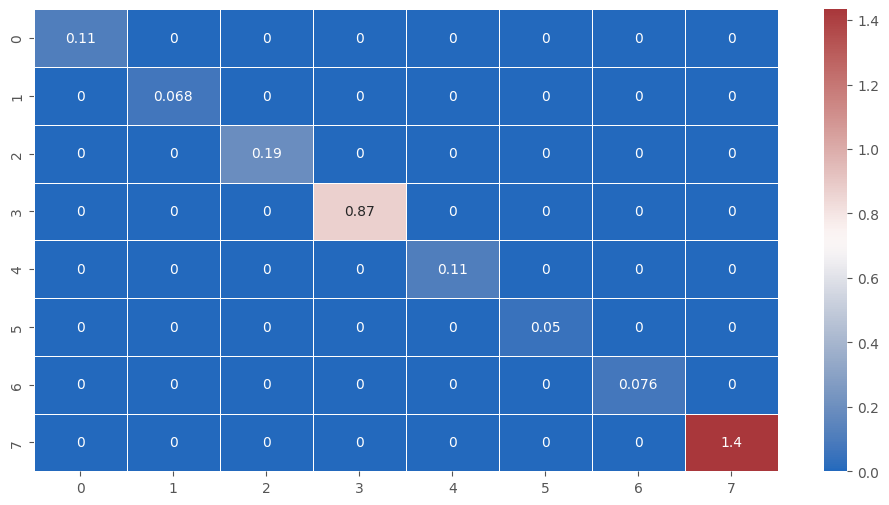

In [31]:
model_RBF = train_GPR_RBF_model(X_train, Y_train)

In [32]:
train_rmse_stan, test_rmse_stan = measure_rmse(model_RBF, X_train, Y_train, X_test, Y_test)
print('Train RMSE (Standardised): %.3f'%(train_rmse_stan))
print('Test RMSE (Standardised): %.3f'%(test_rmse_stan))

Train RMSE (Standardised): 0.205
Test RMSE (Standardised): 0.290


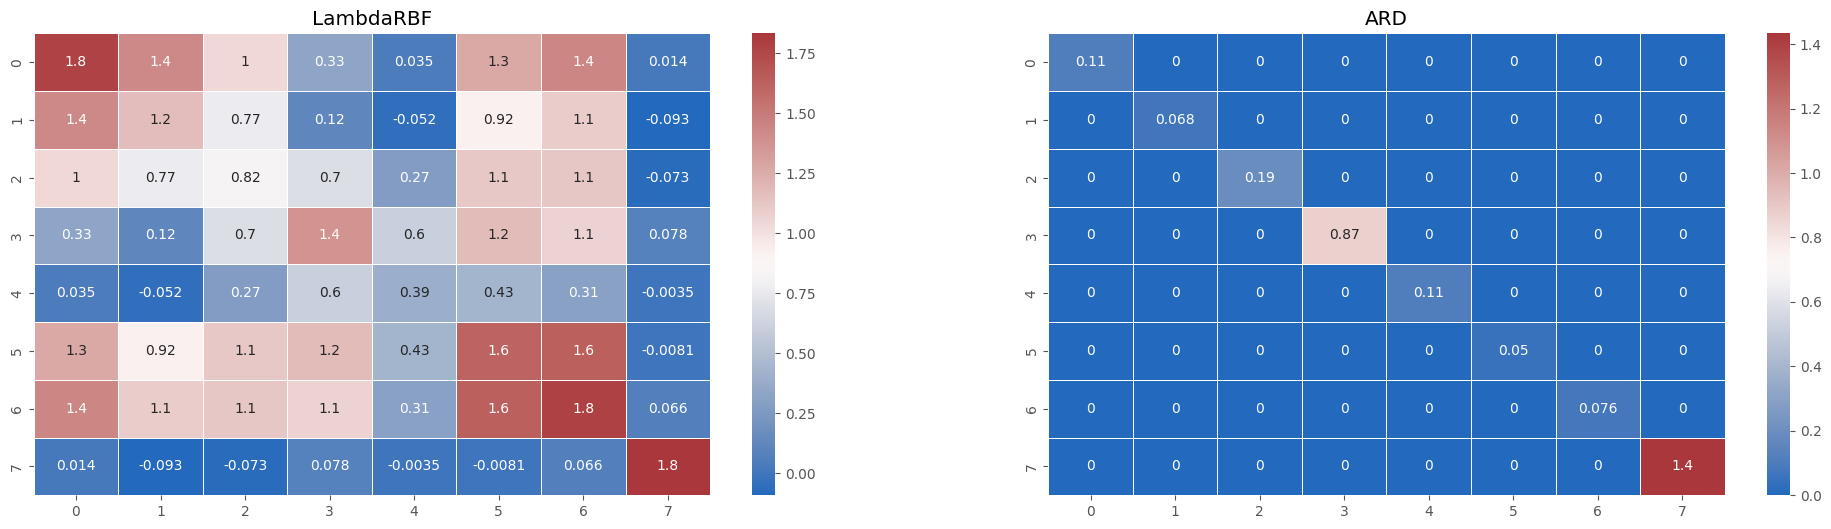

In [33]:
Lambda_LRBF = model_LRBF.kernel.get_Lambda()
Lambda_L_RBF = get_lower_triangular_from_diag(model_RBF.kernel.lengthscales.numpy())
Lambda_RBF = tf.matmul(Lambda_L_RBF, tf.transpose(Lambda_L_RBF))
compare_matrix(Lambda_LRBF, Lambda_RBF)

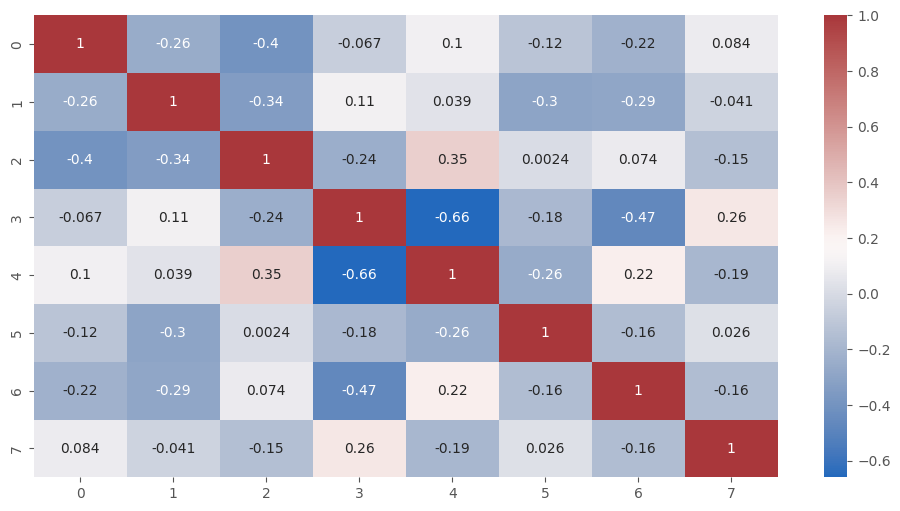

In [34]:
plot_matrix(X_train, correlation=True)